## MICCAI Viz Subnetwork

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-02-04 21:24:03.000058: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 21:24:04.541686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 21:24:06.537755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# overall imports
import importlib
import data

# importlib.reload(data.data_utils)
# importlib.reload(data.data_load)
#importlib.reload(sim.sim_utils)
# importlib.reload(models)

import models
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results, run_simulation_set


## Results visualization

In [4]:
# cross-validation classes
from data.cv_split import (
    RandomCVSplit, 
    SchaeferCVSplit, 
    CommunityCVSplit, 
    SubnetworkCVSplit, 
    SpatialCVSplit
)

schaefer_obj = SchaeferCVSplit()
schaefer_networks = list(schaefer_obj.networks.keys())

In [5]:
results_df = pd.read_csv('LM_Feb5_schaefer.csv')
print(results_df.shape)

print(results_df['Tags'].iloc[0])

(197, 25)
cv_type_schaefer, feature_type_transcriptome, final_eval, gene_list_0.2, hemisphere_both, model_shared_transformer, omit_subcortical_False, outerfold_4, parcellation_S100, split_schaefer1, target_SC


In [6]:
results_df = pd.read_csv('LM_Feb5_schaefer.csv')
print('original shape: ', results_df.shape)

# Get column names that we want to keep
cols_to_keep = [col for col in results_df.columns if 
                col in ['Name', 'Tags'] or 
                'final_train_metrics' in col or 
                'final_test_metrics' in col]

# Drop all other columns
results_df = results_df[cols_to_keep]
results_df.head(20)

# Extract tags into separate columns
def extract_tag_value(tag_str, prefix):
    # Find tag that starts with prefix
    for tag in tag_str.split(', '):
        if tag.startswith(prefix):
            # Return everything after the prefix
            return tag[len(prefix):]
    return None

# Define the tag prefixes we want to extract
tag_prefixes = [
    'cv_type_',
    'feature_type_', 
    'gene_list_',
    'hemisphere_',
    'model_',
    'omit_subcortical_',
    'outerfold_',
    'parcellation_',
    'split_',
    'target_'
]

# Create new columns for each tag type
for prefix in tag_prefixes:
    col_name = prefix.rstrip('_')  # Remove trailing underscore for column name
    results_df[col_name] = results_df['Tags'].apply(lambda x: extract_tag_value(x, prefix))

# Drop original Tags column if desired
results_df = results_df.drop('Tags', axis=1)

# Display first few rows to verify
results_df.head()

original shape:  (197, 25)


,Name,final_test_metrics.geodesic_distance,final_test_metrics.mae,final_test_metrics.mse,final_test_metrics.pearson_corr,final_test_metrics.r2,final_train_metrics.geodesic_distance,final_train_metrics.mae,final_train_metrics.mse,final_train_metrics.pearson_corr,...,cv_type,feature_type,gene_list,hemisphere,model,omit_subcortical,outerfold,parcellation,split,target
0,shared_transformer_transcriptome_SC_schaefer_f...,1.594445,1.810938,4.500048,0.897115,0.705998,7.926983,0.596868,0.678995,0.968890,...,schaefer,transcriptome,0.2,both,shared_transformer,False,4,S100,schaefer1,SC
1,dynamic_mlp_euclidean_SC_schaefer_fold4_final_...,3.526296,1.981882,8.242173,0.844910,0.461514,13.336440,1.035324,4.839267,0.746537,...,schaefer,euclidean,0.2,both,dynamic_mlp,False,4,S100,schaefer1,SC
2,dynamic_mlp_euclidean_SC_schaefer_fold0_final_...,3.617550,1.808390,6.742900,0.811161,0.648021,11.559418,1.188794,5.649902,0.732214,...,schaefer,euclidean,0.2,both,dynamic_mlp,False,0,S100,schaefer1,SC
3,shared_transformer_transcriptome+euclidean_SC_...,2.732470,3.108160,14.669045,0.806222,0.041627,11.421215,1.100826,3.985900,0.785917,...,schaefer,transcriptome+euclidean,0.2,both,shared_transformer,False,4,S100,schaefer1,SC
4,dynamic_mlp_euclidean_SC_schaefer_fold1_final_...,3.371395,2.064485,9.730232,0.754216,0.425576,11.291821,1.014763,4.517031,0.780781,...,schaefer,euclidean,0.2,both,dynamic_mlp,False,1,S100,schaefer1,SC


In [7]:
# Sort dataframe by final_test_metrics.pearson_corr in descending order
results_df = results_df.sort_values(by='final_test_metrics.pearson_corr', ascending=False)

# Display first few rows to verify sorting
results_df.head()
print(f"Shape before removing duplicates: {results_df.shape}")

# Keep only the row with highest pearson correlation for each unique name
results_df = results_df.sort_values('final_test_metrics.pearson_corr', ascending=False)
results_df = results_df.drop_duplicates(subset='Name', keep='first')
print(f"Shape after removing duplicates: {results_df.shape}")

Shape before removing duplicates: (197, 21)
Shape after removing duplicates: (160, 21)


In [8]:
# Update model name for transcriptome+euclidean feature type
results_df.loc[results_df['feature_type'] == 'transcriptome+euclidean', 'model'] = 'shared_transformer_cls'

# Create separate dataframes based on feature types
transcriptome_df = results_df[results_df['feature_type'].isin(['transcriptome', 'transcriptome+euclidean'])]
euclidean_df = results_df[results_df['feature_type'] == 'euclidean']

print(f"Shape of transcriptome/combined models: {transcriptome_df.shape}")
print(f"Shape of euclidean-only models: {euclidean_df.shape}")

# Create separate dataframes for SC and FC targets from transcriptome models
transcriptome_sc_df = transcriptome_df[transcriptome_df['target'] == 'SC']
transcriptome_fc_df = transcriptome_df[transcriptome_df['target'] == 'FC']

# Create separate dataframes for SC and FC targets from euclidean models
euclidean_sc_df = euclidean_df[euclidean_df['target'] == 'SC'] 
euclidean_fc_df = euclidean_df[euclidean_df['target'] == 'FC']

print(f"Shape of transcriptome SC models: {transcriptome_sc_df.shape}")
print(f"Shape of transcriptome FC models: {transcriptome_fc_df.shape}")
print(f"Shape of euclidean SC models: {euclidean_sc_df.shape}")
print(f"Shape of euclidean FC models: {euclidean_fc_df.shape}")


Shape of transcriptome/combined models: (128, 21)
Shape of euclidean-only models: (32, 21)
Shape of transcriptome SC models: (64, 21)
Shape of transcriptome FC models: (64, 21)
Shape of euclidean SC models: (16, 21)
Shape of euclidean FC models: (16, 21)


In [9]:
results_df = transcriptome_sc_df
# Sort dataframe by model type and outerfold
results_df = results_df.sort_values(by=['model', 'outerfold'])
results_df.head(50)




,Name,final_test_metrics.geodesic_distance,final_test_metrics.mae,final_test_metrics.mse,final_test_metrics.pearson_corr,final_test_metrics.r2,final_train_metrics.geodesic_distance,final_train_metrics.mae,final_train_metrics.mse,final_train_metrics.pearson_corr,...,cv_type,feature_type,gene_list,hemisphere,model,omit_subcortical,outerfold,parcellation,split,target
110,bilinear_lowrank_transcriptome_SC_schaefer_fol...,5.339591,3.772275,1.848971e+01,0.274837,3.483712e-02,18.466837,2.233178,8.548650,0.487850,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,0,S100,schaefer1,SC
75,bilinear_lowrank_transcriptome_SC_schaefer_fol...,5.996883,3.638161,1.717362e+01,0.352305,-1.384485e-02,16.413718,2.469726,8.330784,0.508226,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,1,S100,schaefer1,SC
131,bilinear_lowrank_transcriptome_SC_schaefer_fol...,7.046612,3.041992,1.548780e+01,0.214901,-6.276414e-02,18.427630,2.237491,7.885224,0.502125,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,2,S100,schaefer1,SC
47,bilinear_lowrank_transcriptome_SC_schaefer_fol...,6.401368,2.456285,1.076566e+01,0.463151,1.536013e-01,20.311878,2.099572,7.740561,0.500955,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,3,S100,schaefer1,SC
22,bilinear_lowrank_transcriptome_SC_schaefer_fol...,3.276154,3.623198,1.898043e+01,0.591188,-2.400485e-01,21.276017,1.884989,7.955009,0.523317,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,4,S100,schaefer1,SC
54,bilinear_lowrank_transcriptome_SC_schaefer_fol...,5.959726,2.756862,1.137829e+01,0.438294,1.158037e-01,18.964682,2.163850,7.790686,0.505601,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,5,S100,schaefer1,SC
93,bilinear_lowrank_transcriptome_SC_schaefer_fol...,9.620565,2.843063,1.285709e+01,0.310572,4.118953e-02,18.121302,2.294050,8.364394,0.457596,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,6,S100,schaefer1,SC
192,bilinear_lowrank_transcriptome_SC_schaefer_fol...,3.594062,3.645424,1.869983e+01,-0.157210,-5.465330e-01,19.386415,2.218770,7.998129,0.424436,...,schaefer,transcriptome,0.2,both,bilinear_lowrank,False,7,S100,schaefer1,SC
103,dynamic_mlp_transcriptome_SC_schaefer_fold0_fi...,13.297472,4.152892,3.251121e+01,0.286789,-6.970855e-01,32.030233,1.350414,7.791268,0.623906,...,schaefer,transcriptome,0.2,both,dynamic_mlp,False,0,S100,schaefer1,SC
58,dynamic_mlp_transcriptome_SC_schaefer_fold1_fi...,5.664940,2.873607,1.655780e+01,0.425227,2.251021e-02,25.138099,1.120699,6.075298,0.703219,...,schaefer,transcriptome,0.2,both,dynamic_mlp,False,1,S100,schaefer1,SC


In [77]:
schaefer_networks


['Vis',
 'SomMot',
 'DorsAttn',
 'SalVentAttn',
 'Limbic',
 'Cont',
 'Default',
 'Subcortical']

  ranks = results_df.groupby('outerfold').apply(get_ranks).reset_index(level=0, drop=True)



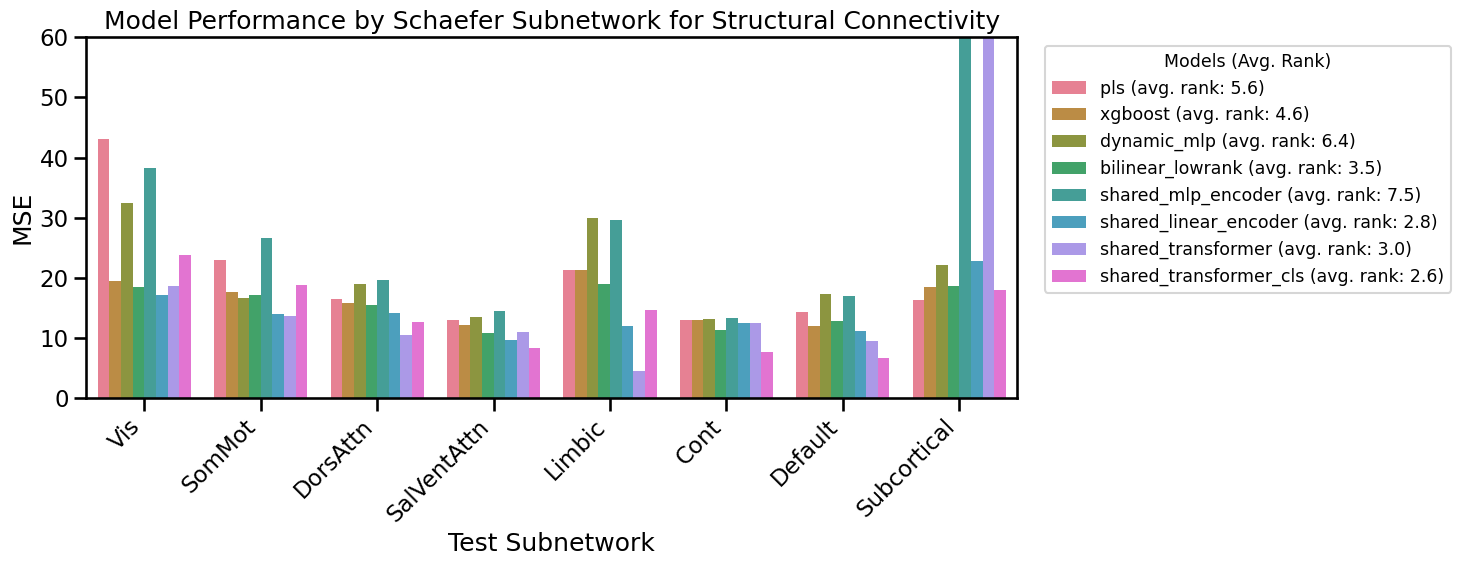

In [79]:
# Set up the plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose metric to plot (can be modified)
metric_col = 'final_test_metrics.mse'

# Define model order and color palette
model_order = ['dynamic_mlp', 'xgboost'] if 'euclidean' in results_df['feature_type'].iloc[0] else \
              ['pls', 'xgboost', 'dynamic_mlp', 'bilinear_lowrank', 
               'shared_mlp_encoder', 'shared_linear_encoder', 'shared_transformer', 
               'shared_transformer_cls']

# Function to get ranks within each fold (higher metric = worse for MSE)
def get_ranks(group):
    if 'mse' in metric_col.lower():
        return group[metric_col].rank()  # Ascending for MSE (lower is better)
    else:
        return group[metric_col].rank(ascending=False)  # Descending for pearson/r2 (higher is better)

# Calculate average ranks
ranks = results_df.groupby('outerfold').apply(get_ranks).reset_index(level=0, drop=True)
avg_ranks = ranks.groupby(results_df['model']).mean()

# Create a custom colormap using seaborn's color palettes
colors = sns.color_palette("husl", n_colors=len(model_order))

# Create figure with wider size
plt.figure(figsize=(15, 6))

# Create bar plot with ordered models
sns.barplot(data=results_df, 
            x='outerfold',
            y=metric_col,
            hue='model',
            hue_order=model_order,
            palette=colors,
            ci=None)

# Get target type from dataframe
target_type = results_df['target'].iloc[0]  # Get first value since all should be same
target_name = 'Structural Connectivity' if target_type == 'SC' else 'Functional Connectivity'

# Get y-axis label based on metric
ylabel_metric = 'Pearson-r' if 'pearson' in metric_col.lower() else \
               'MSE' if 'mse' in metric_col.lower() else \
               'R²' if 'r2' in metric_col.lower() else metric_col

plt.title(f'Model Performance by Schaefer Subnetwork for {target_name}')
plt.xlabel('Test Subnetwork')
plt.ylabel(ylabel_metric)

# Set y-axis limits based on metric
if 'pearson' in metric_col.lower() or 'r2' in metric_col.lower():
    plt.ylim(0, 1)
elif 'mse' in metric_col.lower():
    plt.ylim(0, 60)

# Replace x-axis numeric labels with network names
plt.xticks(range(len(schaefer_networks)), schaefer_networks, rotation=45, ha='right')

# Create legend labels with average ranks
legend_labels = [f'{model} (avg. rank: {avg_ranks[model]:.1f})' for model in model_order]

# Add legend with title and modified labels
legend = plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', 
                   fontsize='x-small', markerscale=0.7, 
                   title='Models (Avg. Rank)')
plt.setp(legend.get_title(), fontsize='x-small')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()
